In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

**STEP 1 - Get the data**

In [0]:
classes = ['knife', 'katana']
path = Path('data')
for c in classes:
  folder = c
  file = c + '.csv'
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(file, dest, max_pics=700, max_workers=0)
  print(c)
  verify_images(path/c, delete=True, max_size=500)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['katana', 'knife']

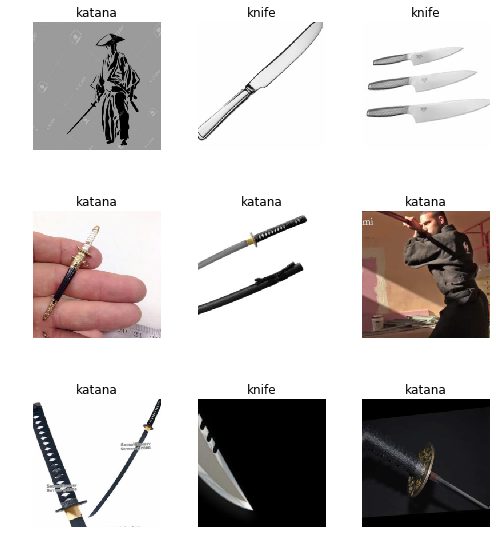

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['katana', 'knife'], 2, 896, 223)

**STEP 3 - Train model**

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 79496994.06it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.578421,0.198967,0.062780,00:20
1,0.367571,0.162521,0.053812,00:19
2,0.285021,0.167555,0.053812,00:18
3,0.236581,0.161874,0.053812,00:19


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


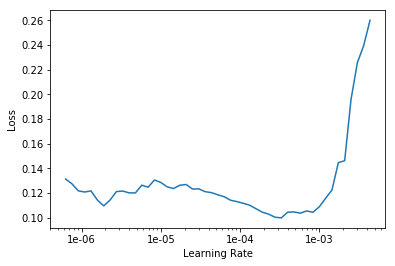

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.042364,0.183282,0.044843,00:20
1,0.031796,0.195839,0.049327,00:20


In [0]:
learn.save('stage-2')

**STEP 4** - INTERPRETATION

In [0]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (896 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
knife,knife,knife,knife,knife
Path: data;

Valid: LabelList (223 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
knife,knife,katana,katana,knife
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

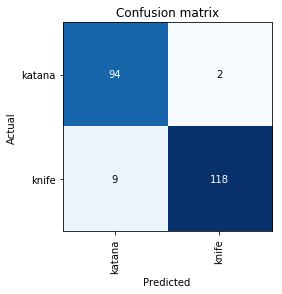

In [0]:
interp.plot_confusion_matrix()

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                .split_none()
                .label_from_folder()
                .transform(get_transforms(), size=224)
                .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1119 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
knife,knife,knife,knife,knife
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

**STEP #** - Putting into production

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

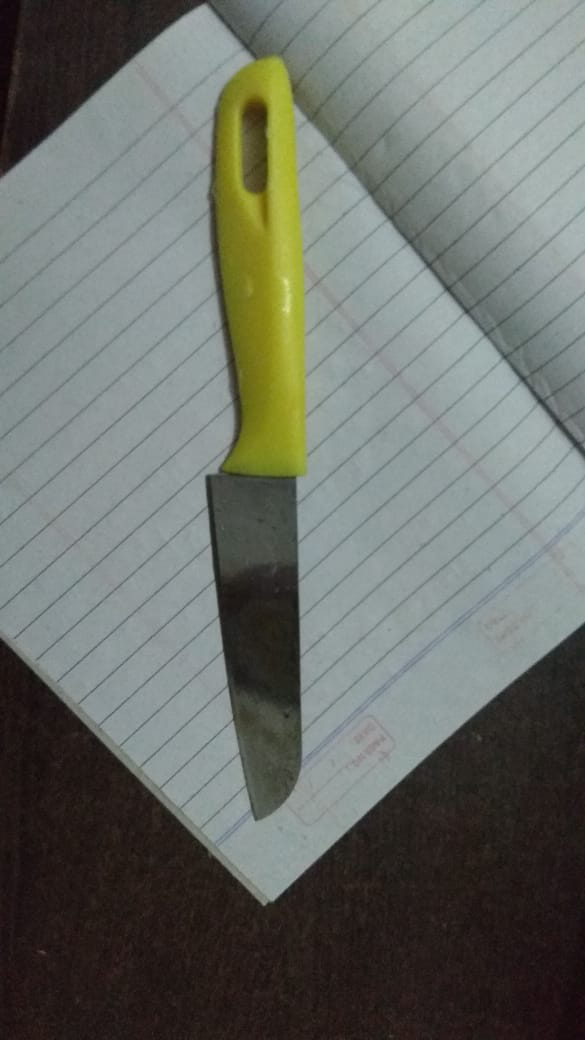

In [0]:
img = open_image(path/'faca2.jpeg')
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category katana

In [0]:
bs = 16
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, 
                                 ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)

In [7]:
learn50 = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89184563.10it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


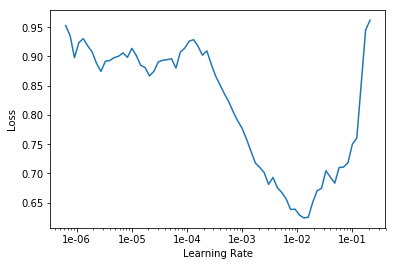

In [8]:
learn50.lr_find()
learn50.recorder.plot()

In [9]:
learn50.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.406106,0.157138,0.066964,00:36
1,0.348607,0.197396,0.080357,00:36
2,0.324269,0.212799,0.084821,00:36
3,0.272164,0.163672,0.071429,00:36
4,0.242204,0.107858,0.044643,00:36
5,0.205377,0.116870,0.040179,00:36
6,0.188530,0.122867,0.058036,00:36
7,0.185666,0.110656,0.040179,00:36


In [0]:
learn50.save('stage-1-50')

In [13]:
learn50.unfreeze()
learn50.fit_one_cycle(3, max_lr=slice(1e-2, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,4.478686,12.596374,0.558036,00:47
1,4.115875,32225.111328,0.491071,00:46
2,1.542730,36801.414062,0.419643,00:46


In [0]:
learn50.load('stage-1-50')
interp = ClassificationInterpretation.from_learner(learn50)

In [15]:
interp.most_confused(min_val=2)

[('katana', 'knife', 7), ('knife', 'katana', 2)]

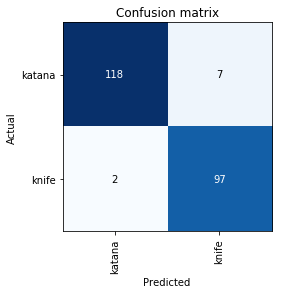

In [16]:
interp.plot_confusion_matrix()

In [0]:
learn50.export()

In [0]:
defaults.device = torch.device('cpu')

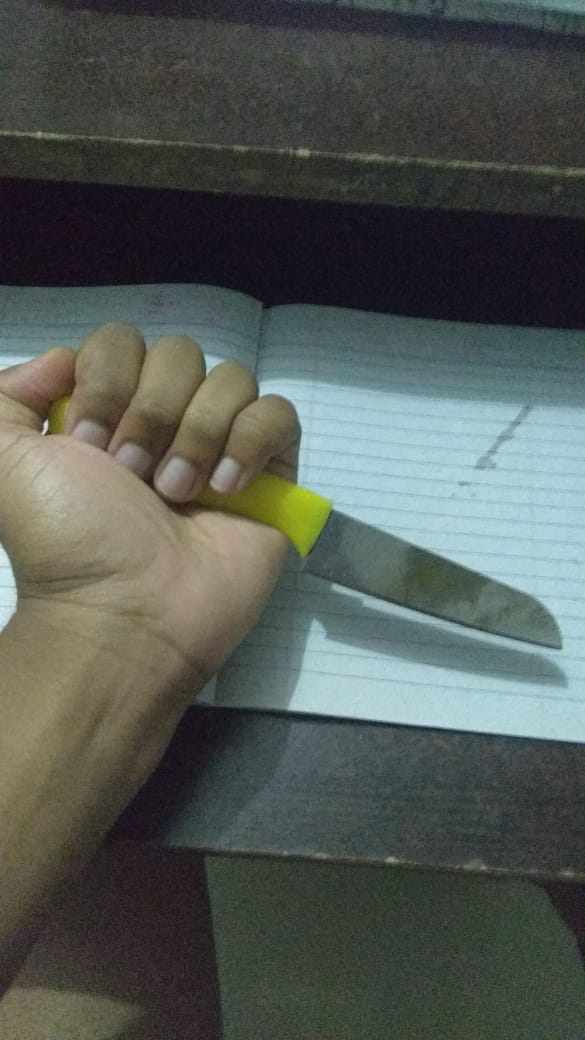

In [19]:
img = open_image(path/'faca1.jpeg')
img

In [0]:
learn50 = load_learner(path)

In [21]:
pred_class,pred_idx,outputs = learn50.predict(img)
pred_class

Category knife

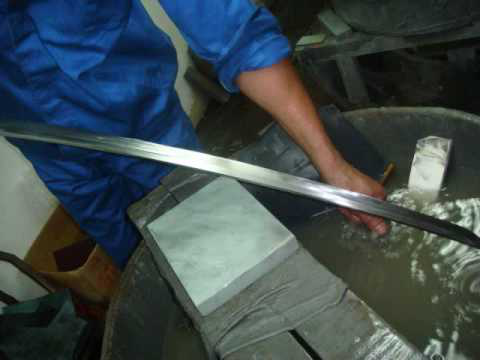

In [22]:
espada = open_image(path/'katana'/'00000000.jpg')
espada

In [23]:
pred_class,pred_idx,outputs = learn50.predict(espada)
pred_class

Category katana

In [24]:
espada = open_image(path/'espada.jpg')
espada
pred_class,pred_idx,outputs = learn50.predict(espada)
pred_class

Category katana

In [25]:
faca2 = open_image(path/'faca2.jpeg')
pred_class,pred_idx,outputs = learn50.predict(faca2)
pred_class

Category knife

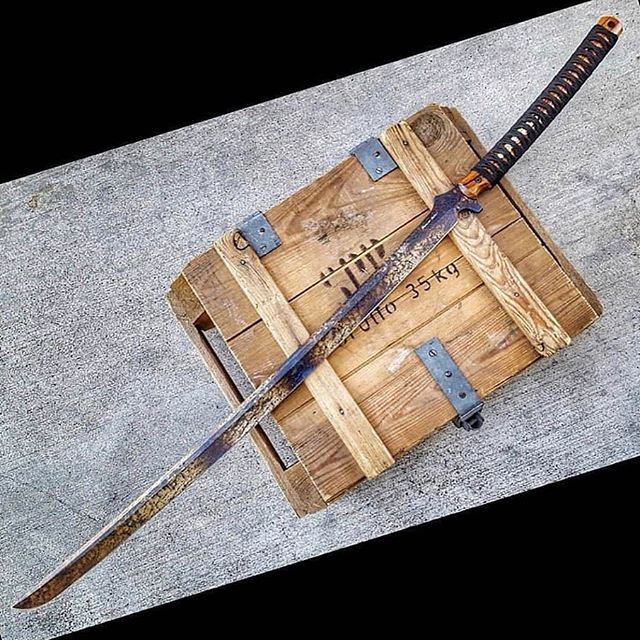

In [26]:
espada

In [27]:
learn50.recorder.plot_losses()

AttributeError: ignored